توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
%%capture
!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
def crop_center(img, l):
    w, h, _ = img.shape
    mid_x, mid_y = int(w/2), int(h/2)
    crop_img = img[mid_x-int(l/2):mid_x+int(l/2), mid_y-int(l/2):mid_y+int(l/2),:]
    return crop_img

# function 1
def displacement(img, l):
  ## To Do
  w, h, _ = img.shape
  s_x = random.randint(0, w-l-1)
  s_y = random.randint(0, h-l-1)
  displaced_img = img[s_x:s_x + l, s_y:s_y + l,:]
  return displaced_img

# function 2
def rotation(img):
  ## To Do
  angle = np.random.uniform(-90, 90)
  w, h, _ = img.shape
  matrix = cv2.getRotationMatrix2D((h/ 2, w/ 2), angle, 1)
  rotated_img = cv2.warpAffine(img, matrix, (h, w))
  return rotated_img


# function 3
def scaling(img):
  ## To Do
  f = np.random.uniform(0.5, 1.5)
  scaled_image = cv2.resize(img, None, fx = f, fy = f)
  return scaled_image



# function 4
def Brightness(img):  ## for augmentation
  ## To Do
  brightness_factor = 0.8+np.random.rand()*0.4
  bright_img = img*brightness_factor
  bright_img = np.clip(bright_img, 0, 255).astype(np.unit8)
  return bright_img



# function 5
def bluring(img):# for augmentation
  ## To Do
  kernel_size = 5
  blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
  return blurred_img

# function 6
def gaussian_noise(img):#for augmentation
  ## To Do
  noise = np.random.normal(0, 25, img.shape).astype(np.unit8)
  noisy_img = cv2.add(img,noise)
  return noisy_img

In [4]:
def apply_transformations(img):
  l =224
  img1 = crop_center(img, l)
  # vector: [displacement, rotation, scaling]
  label = torch.zeros(3)
  num_transforms = random.randint(0, 2)  # Apply 0, 1 or 2 transformations
  if num_transforms==2:
    img2 = rotation(img)
    img2 = scaling(img2)
    img2 = crop_center(img2, l)
    label[1] = 1
    label[2] = 1
  else:
    if num_transforms==1:
      c = random.randint(1, 2)
      if c==1:
        img2 = rotation(img)
      else:
        img2 = scaling(img)
      label[c]=1
      c = random.randint(-1, 0)
      if c==0:
        img2 = displacement(img2, l)
        label[c] = 1
      else:
        img2 = crop_center(img2, l)
    else:
      c = random.randint(-1, 0)
      if c==0:
        img2 = displacement(img, l)
        label[c] = 1
      else:
        img2 = crop_center(img, l)

  return img1, img2, label

class CustomDataset(Dataset):
    def __init__(self, dir):
      self.img_paths = [os.path.join(dir, filename) for filename in os.listdir(dir)]
      self.transform = transforms.Compose([
            transforms.ToTensor()])

    def __len__(self):
      return len(self.img_paths)

    def __getitem__(self, idx):
      img_path = self.img_paths[idx]
      img = cv2.imread(img_path)
      s = 600
      img = cv2.resize(img, (s, s))
      img1, img2, label = apply_transformations(img)
      img1 = self.transform(img1)
      img2 = self.transform(img2)
      return img1, img2, label

In [25]:
# Create datasets
dataset_train = CustomDataset("/content/ADEChallengeData2016/images/training")
dataset_test = CustomDataset("/content/release_test/testing")
dataset_val = CustomDataset("/content/ADEChallengeData2016/images/validation")

# Set up DataLoader for training, testing, and validation sets
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)

-------------------Images from Train Loader--------------------
img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


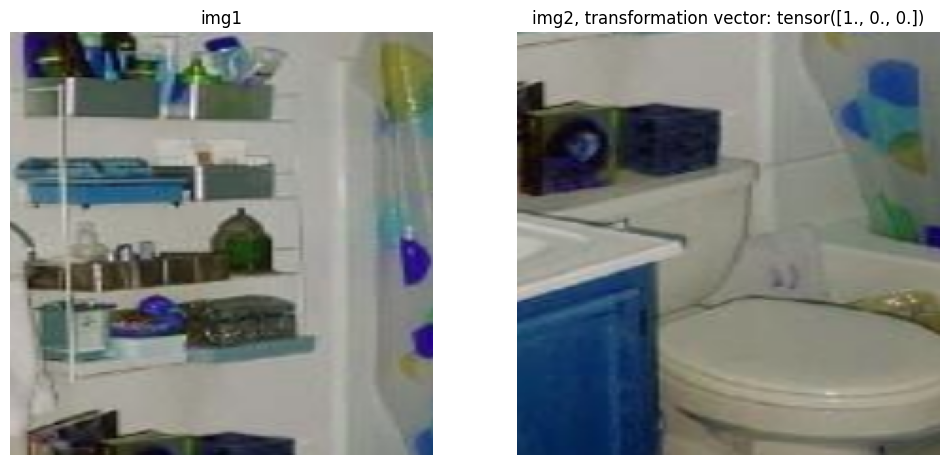

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


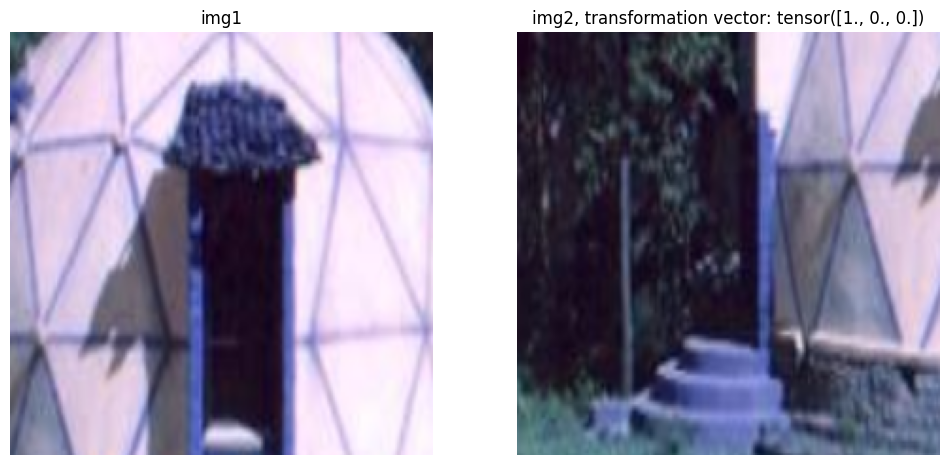

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


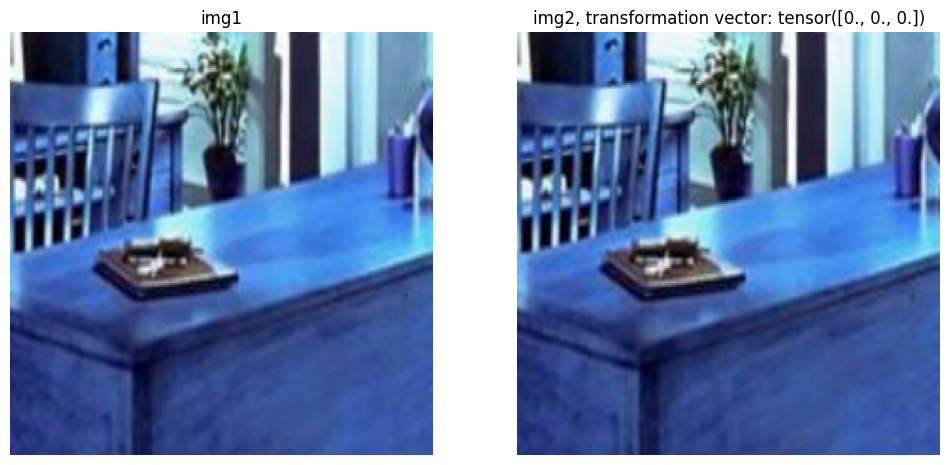

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


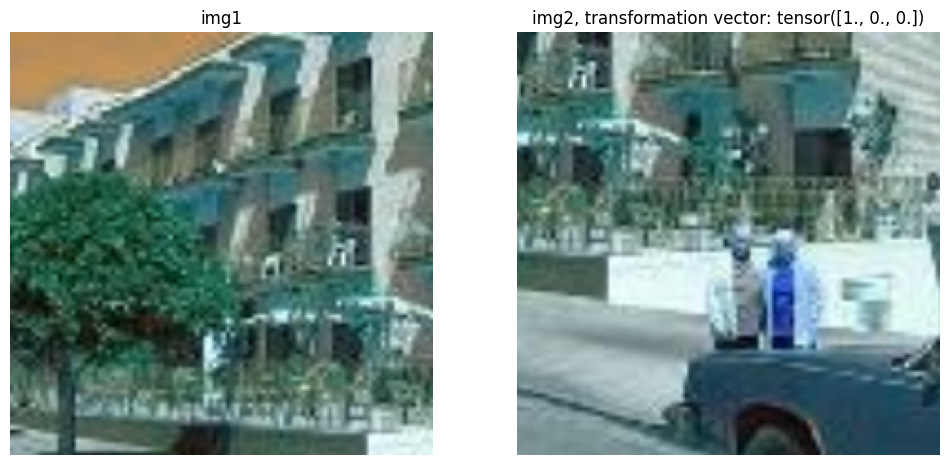

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


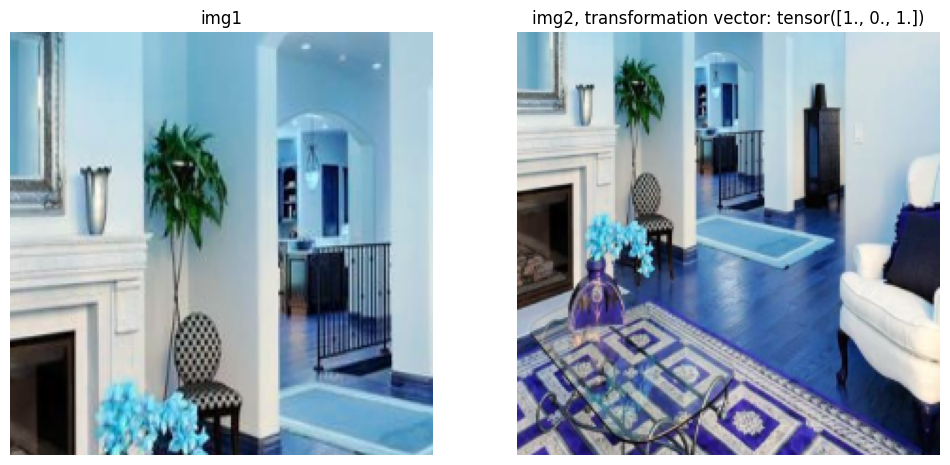

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


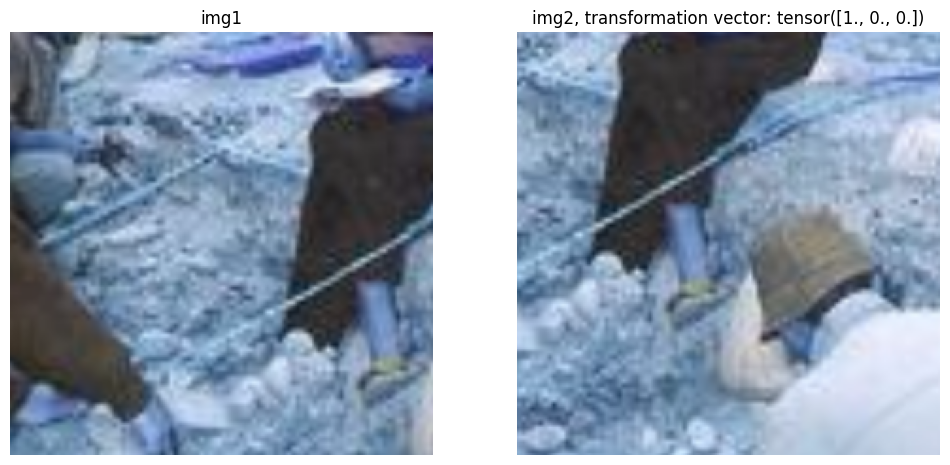

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


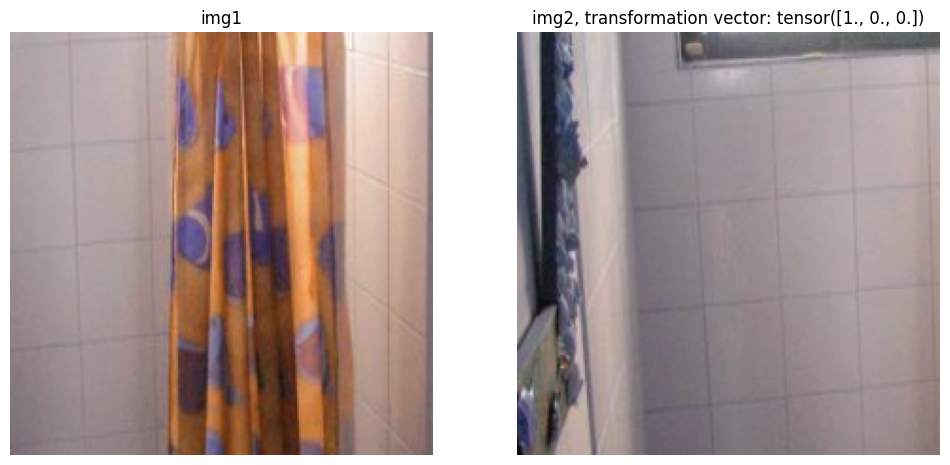

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


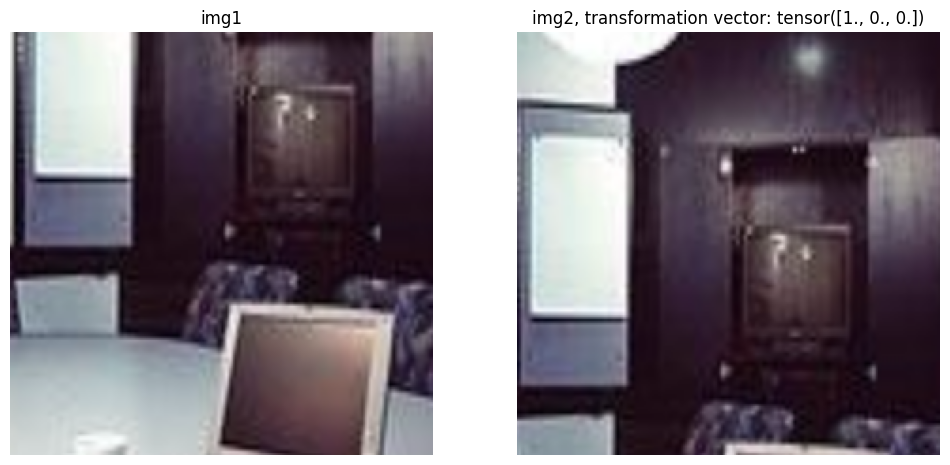

-------------------Images from Test Loader--------------------
img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


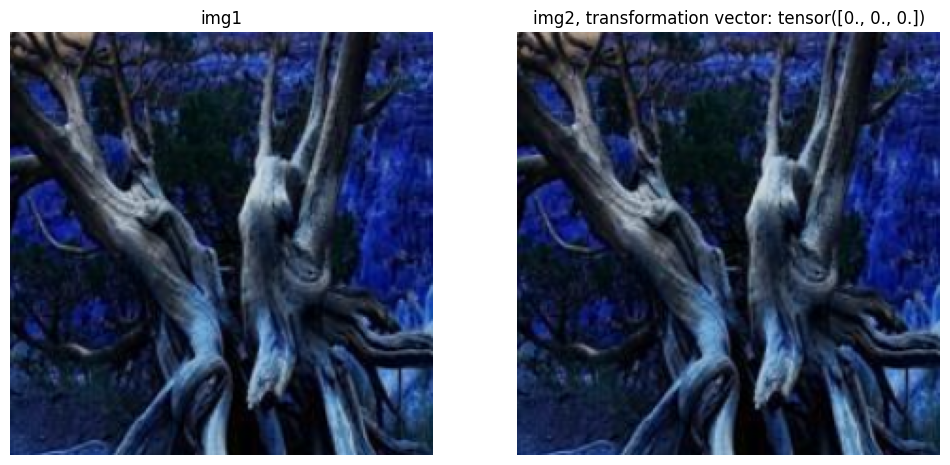

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


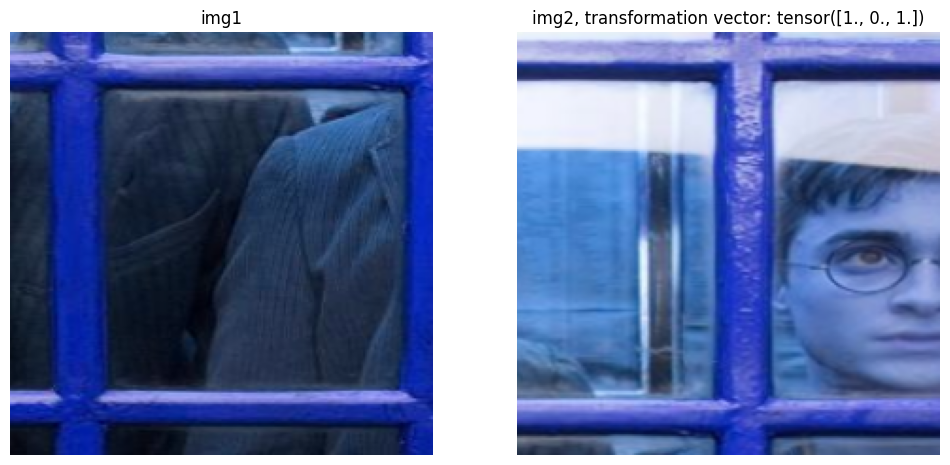

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


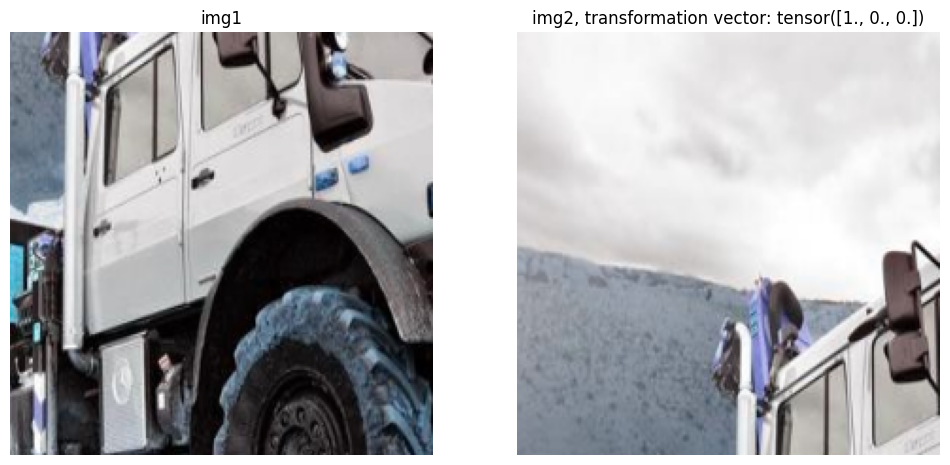

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


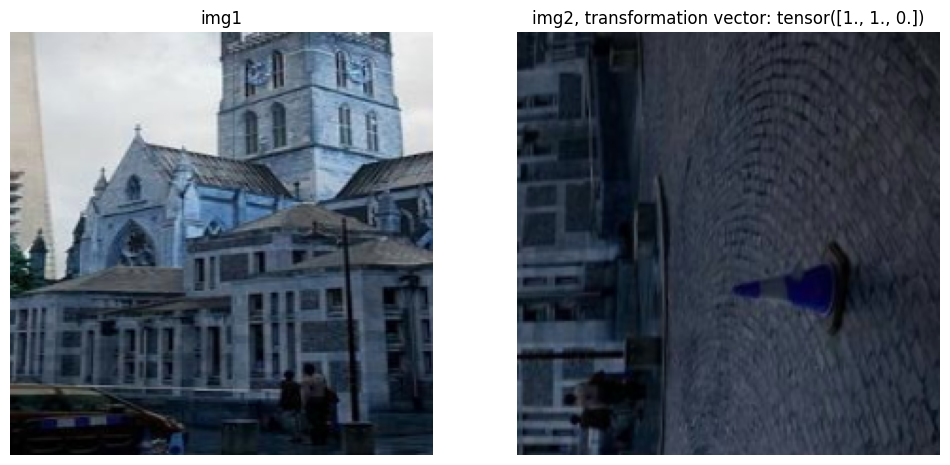

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


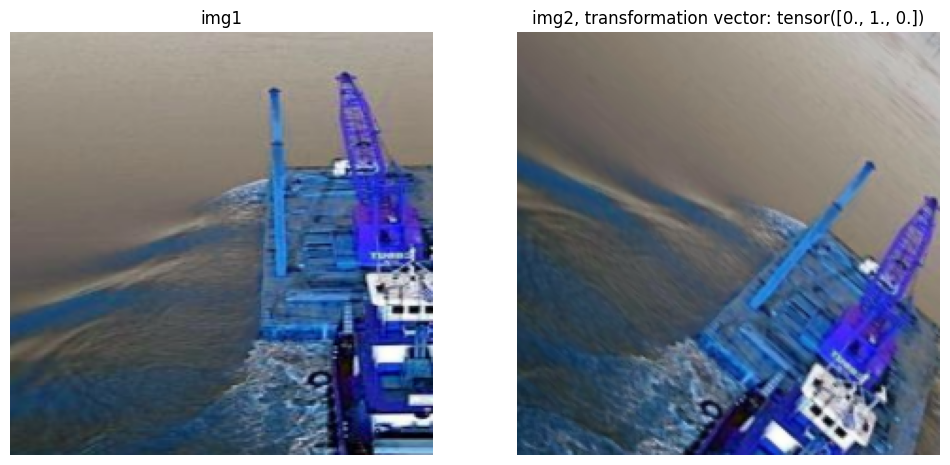

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


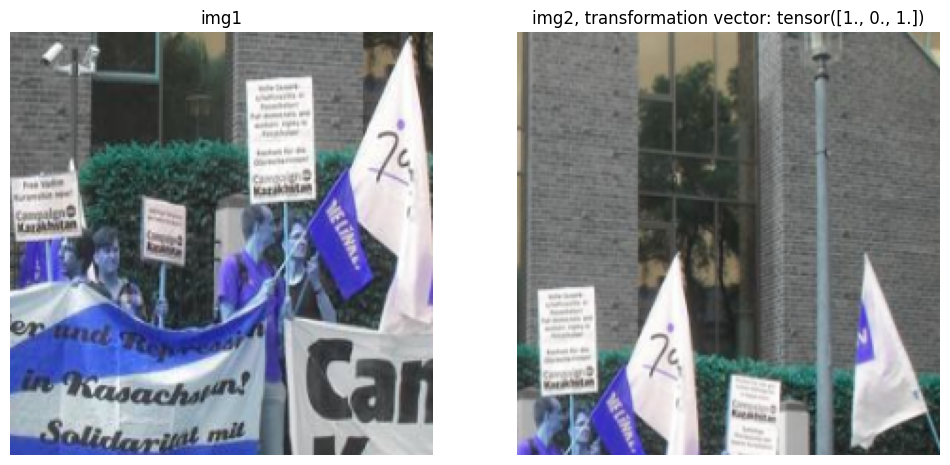

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


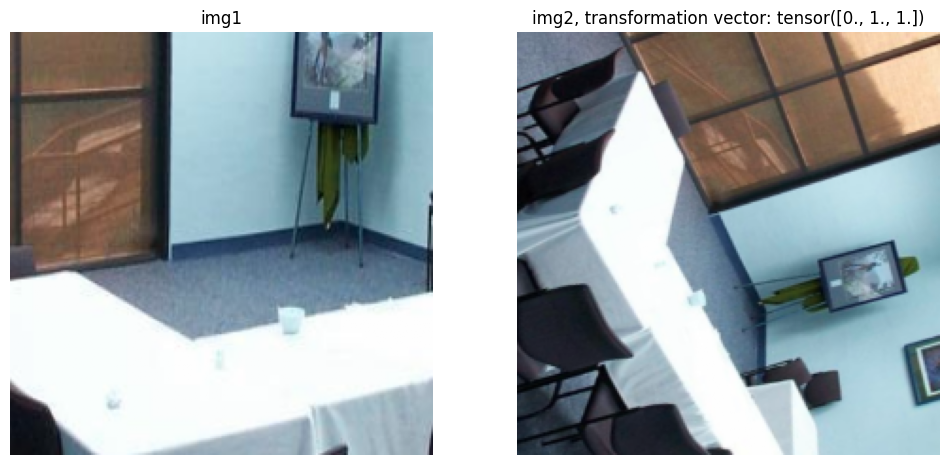

img1 size:  torch.Size([3, 224, 224])
img2 size:  torch.Size([3, 224, 224])


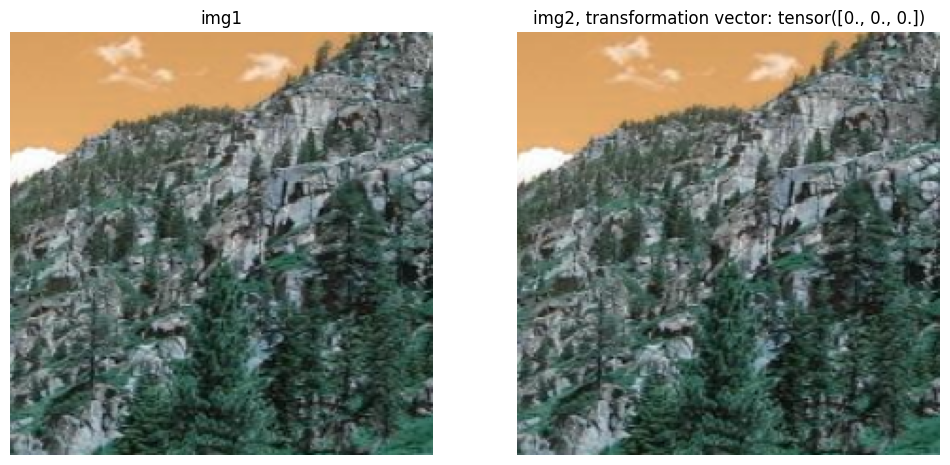

In [6]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
def show_images(loader, title):
    img1, img2, label = next(iter(loader))
    print("-------------------"+title+"--------------------")
    for i in range(8):
        plt.figure(figsize=(12, 6))
        plt.subplot(1,2, 1)
        plt.imshow(img1[i].permute(1, 2, 0).numpy())
        print("img1 size: ", img1[i].shape)
        plt.title("img1")
        plt.axis('off')
        plt.subplot(1,2, 2)
        plt.imshow(img2[i].permute(1, 2, 0).numpy())
        print("img2 size: ", img2[i].shape)
        plt.title("img2, transformation vector: "+str(label[i]))
        plt.axis('off')
        plt.show()

# Show images from train_loader
show_images(train_loader, "Images from Train Loader")

# Show images from test_loader
show_images(test_loader, "Images from Test Loader")



##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

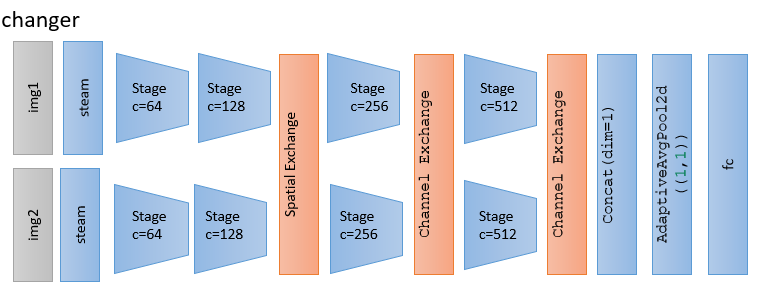

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


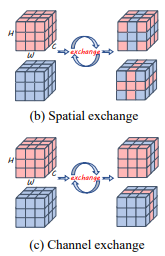

In [7]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

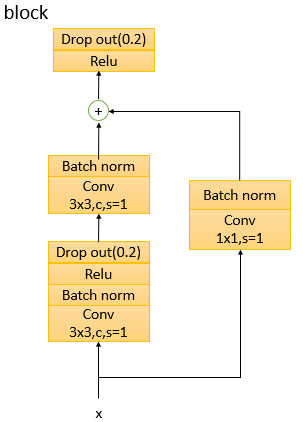

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟

 channel out size (conv(1*1))
 padding(conv)

کلاس استیج از دو بلوک تشکیل شده است. تعداد کانالهای خروجی لایه کانولوشنی یک بدی در بلوک اول استیج برابر همان تعداد کانالهای ورودی در نظر گرفته شده است. اما در بوک دوم از آنجایی که استیج یه یک استیج با تعداد فیلتر دو برابر متصل می شود، تعداد کانالهای خروجی دو برابر شده است.


همچنین پدینگ این لایه برابر 2 انتخاب می شود تا ابعاد تصویر ورودی با تصویر خروجی یکسان شود و بتوان آنها را با هم جمع کرد.
ابعاد ورودی در اینجا اگر 

n*n


باشد، پس از اعمال یک کانولوشن 3 در 3 برابر 

(n-3+2)/1+1=n

خواهد بود. پس برای اینکه ورودی را بتوان با خروجی جمع کرد باید پدینگ برابر 2 اختیار شود تا خروجی پس از این کانولوشن 1 در 1 نیز کماکان 

n

باقی بماند:

(n-1+2)/1+1=n

2.  دلیل استفاده از کانولوشن 1در1 چیست؟

دلیل استفاده از این کانولوشن متعادلسازی تعداد کانالهای ورودی می باشد تا بتوان تصویر ورودی را با تعداد کانال هایی حاصل پس از اعمال دو کانولوشن 3 در 3  جمع کرد.



In [8]:
##To Do
class Block(nn.Module):
    def __init__(self, num_channels, c, strides=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, c*num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv3 = nn.Conv2d(num_channels, c*num_channels, kernel_size=1, padding=0, stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(c*num_channels)
        self.bn3 = nn.BatchNorm2d(c*num_channels)
        self.drop1 = nn.Dropout2d(0.2)
        self.drop2 = nn.Dropout2d(0.2)

    def forward(self, x):
        y = self.drop1(nn.functional.relu(self.bn1(self.conv1(x))))
        y = self.bn2(self.conv2(y))
        x = self.bn3(self.conv3(x))
        y += x
        out = self.drop2(nn.functional.relu(y))

        return out



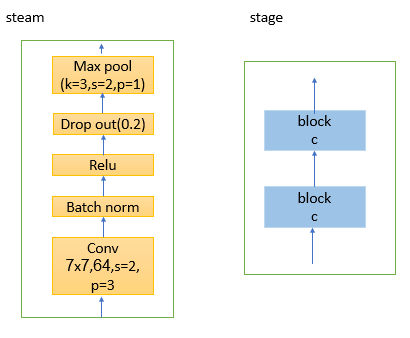

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [9]:
#To Do
class changer(nn.Module):
  def __init__(self, Block, SpatialExchange, ChannelExchange):
    super(changer,self).__init__()


    self.steam1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), nn.ReLU(), nn.Dropout2d(0.2),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    self.steam2 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), nn.ReLU(), nn.Dropout2d(0.2),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


    self.stage11 = self._make_stage(Block, 64)
    self.stage21 = self._make_stage(Block, 128)
    self.stage31 = self._make_stage(Block, 256)
    self.stage41 = self._make_stage(Block, 512)

    self.stage12 = self._make_stage(Block, 64)
    self.stage22 = self._make_stage(Block, 128)
    self.stage32 = self._make_stage(Block, 256)
    self.stage42 = self._make_stage(Block, 512)

    self.SE = SpatialExchange()
    self.CE1 = ChannelExchange()
    self.CE2 = ChannelExchange()

    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Linear(2048, 3)

  def _make_stage(self, Block, num_channels):
    layers=[]
    layers.append(Block(num_channels,1))
    layers.append(Block(num_channels,2))
    return nn.Sequential(*layers)

  def forward(self,x1,x2):
    x1 = self.steam1(x1)
    x2 = self.steam2(x2)

    x1 = self.stage11(x1)
    x2 = self.stage12(x2)

    x1 = self.stage21(x1)
    x2 = self.stage22(x2)

    x1, x2 = self.SE(x1,x2)

    x1 = self.stage31(x1)
    x2 = self.stage32(x2)

    x1, x2 = self.CE1(x1,x2)

    x1 = self.stage41(x1)
    x2 = self.stage42(x2)

    x1, x2 = self.CE2(x1,x2)

    x = torch.cat((x1, x2), dim=1)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [13]:
## To Do
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=changer(Block,SpatialExchange,ChannelExchange).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


##Train & validation


In [16]:
from tqdm import tqdm

num_batches_to_train = 2  # Choose the number of batches you want to train on
num_batches_to_val = 2  # Choose the number of batches you want to use for validation

total_step = min(num_batches_to_train, len(train_loader))
num_epochs = 1

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for batch_idx, (img1, img2, label) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True, total=num_batches_to_train):
        if batch_idx >= num_batches_to_train:
            break
        img1 = img1.to(device)
        img2 = img2.to(device)
        label = label.to(device)

        # Forward pass
        outputs = model(img1, img2)
        loss = criterion(outputs, label)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (img1, img2, label) in tqdm(enumerate(val_loader), desc='Validation', dynamic_ncols=True, total=num_batches_to_val):
            # Break the loop if we have validated on the desired number of batches
            if batch_idx >= num_batches_to_val:
                break

            img1 = img1.to(device)
            img2 = img2.to(device)
            label = label.to(device)
            outputs = model(img1, img2)
            val_loss += criterion(outputs, label).item()

    avg_val_loss = val_loss / min(len(val_loader), num_batches_to_val)
    print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), avg_val_loss))


Validation: 100%|██████████| 2/2 [00:15<00:00,  7.58s/it]

Epoch [1/1], Training Loss: 1.3775, Validation Loss: 1.6785


#Test


In [21]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # Add any other information you want to save, e.g., epoch, loss, etc.
}

# Specify the file path where you want to save the checkpoint
checkpoint_path = 'checkpoint.pth'

# Save the checkpoint
torch.save(checkpoint, checkpoint_path)

In [24]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## To Do test

num_batches_to_test = 2  # Choose the number of batches you want to use for testing

with torch.no_grad():
    test_loss = 0.0

    for batch_idx, (img1, img2, label) in enumerate(test_loader):
        if batch_idx >= num_batches_to_test:
            break

        img1 = img1.to(device)
        img2 = img2.to(device)
        label = label.to(device)
        outputs = model(img1, img2)
        print("label: ", label)
        print("outputs: ", outputs)
        test_loss += criterion(outputs, label).item()

avg_test_loss = test_loss / min(len(test_loader), num_batches_to_test)
print('Test Loss: {:.4f}'.format(avg_test_loss))


label:  tensor([[1., 1., 0.],
        [0., 1., 0.]])
outputs:  tensor([[-0.2923,  0.6101,  0.4309],
        [-0.2720,  0.6236,  0.4057]])
label:  tensor([[0., 1., 0.],
        [0., 0., 1.]])
outputs:  tensor([[-0.5029,  0.8845,  0.3184],
        [-0.3068,  0.7231,  0.3156]])
Test Loss: 1.2550


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

با توجه به نتایج بدست آمده تصاویر با یک تغییر (بردار وان هات لیبل) بهترین پردیکت می شوند.